## FIRE DETECTION
---
* Anggota :
    * Mohamad Muqiit Faturrahman - 152018016
    * Rizkika Siti Syifa - 152018030
    * Siti Asy Syifa - 152018032
* Image Preprocessing
    * Masking
    * Segmentation
    * Image Sharpening
* Deep Learning Model

In [26]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm


from keras.models import Model, Sequential, save_model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical

In [27]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
# !cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
# !ls ~/.keras/models

In [28]:
base_folder = 'fire-dataset'
data_folder = 'fire_dataset'
train_data_folder = 'fire_dataset/fire_images'
test_date_folder = 'fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [29]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 142.96it/s]


In [30]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [31]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.head()

,file,id,label
0,fire_images/fire.1.png,0,fire_images
1,fire_images/fire.10.png,0,fire_images
2,fire_images/fire.100.png,0,fire_images
3,fire_images/fire.101.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


### IMAGE PREPROCESSING

In [32]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    kernel = np.ones((3, 3), np.float32) / 9
    image_filter = cv2.filter2D(image,-1,kernel)
    return image_filter

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

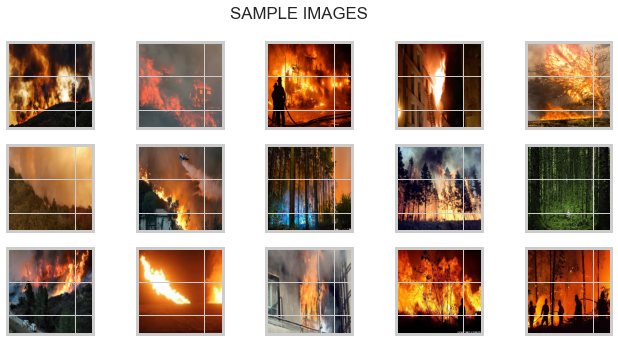

In [33]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5))
plt.suptitle('SAMPLE IMAGES')
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


<ipython-input-34-52cce2f967ce>:12: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)


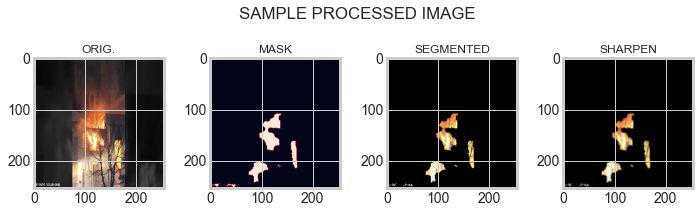

In [34]:
#get an image
img = read_img(df['file'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)



### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [35]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [01:25, 11.68it/s]


In [36]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


#### SPLIT THE DATA

In [37]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [38]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


In [39]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 94s 13s/step


In [40]:
# Xception Model Summary
xception_bf.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [41]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


### DEEP LEARNING MODEL

In [42]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [43]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 0s 17ms/step - loss: 0.5564 - accuracy: 0.7635
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 0.5157 - accuracy: 0.7635

#### LOSS AND ACCURACY

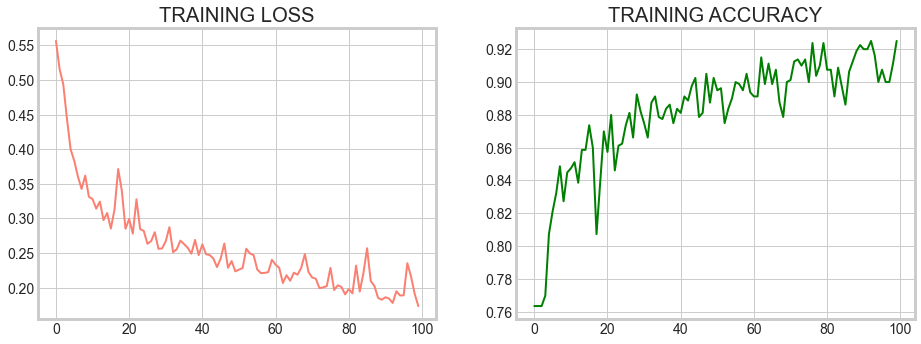

In [44]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')

ax[0].plot(history.history['loss'], color= 'salmon',lw=2)
ax[1].plot(history.history['accuracy'], color= 'green',lw=2)
fig.savefig("fig_training.png")

In [45]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

#### CLASSIFICATION REPORT

In [46]:
print(classification_report(y_val, predictions, target_names=["Non-Fire", "Fire"]))

              precision    recall  f1-score   support

    Non-Fire       0.95      0.83      0.89       145
        Fire       0.66      0.89      0.76        55

    accuracy                           0.84       200
   macro avg       0.81      0.86      0.82       200
weighted avg       0.87      0.84      0.85       200



#### CONFUSION MATRIX

INFO:tensorflow:Assets written to: ./saved_model\assets


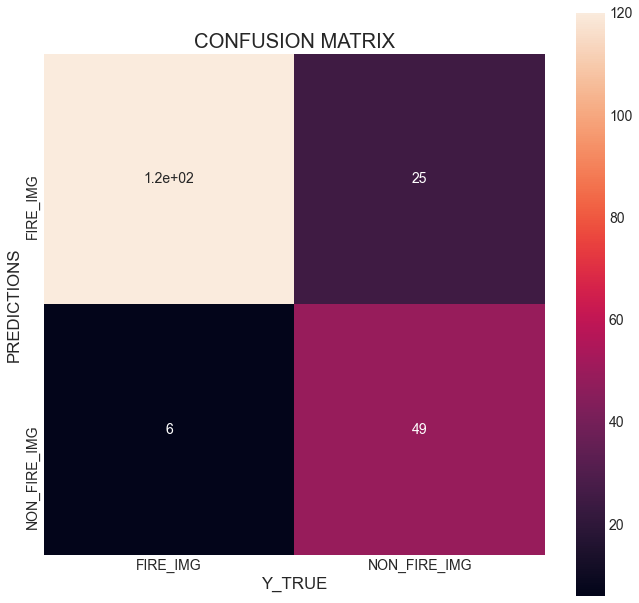

In [47]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG'])
plt.title('CONFUSION MATRIX')
plt.xlabel('Y_TRUE')
plt.ylabel("PREDICTIONS")
plt.savefig("confusion_matrix.png")
# Save model
filepath = './saved_model'
save_model(model, filepath)

In [48]:
from keras.models import load_model
model_loaded = load_model(filepath, compile=True)
predictions = model_loaded.predict_classes(bf_train_val)
print(predictions)

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]]

#### CLASSIFY IMAGES

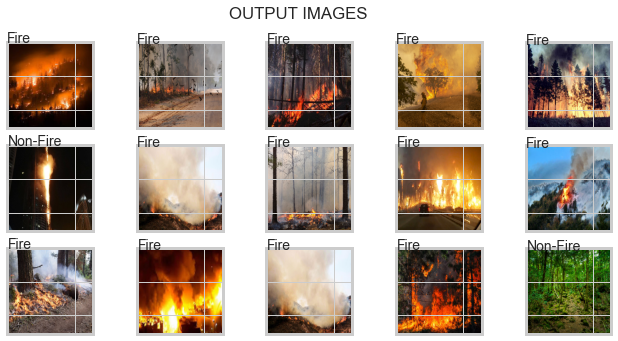

In [49]:
nb_rows = 3
nb_cols = 5
fig_output, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5))
plt.suptitle('OUTPUT IMAGES')
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        seq = np.random.randint(200)
        label = "Fire" if predictions[seq] == 0 else "Non-Fire"
        color = (0, 0, 255) if predictions[seq] == 0 else (0, 255, 0)
        orig = axs[i, j].imshow((read_img(df.iloc[y_val.index.values[seq]]['file'], (255,255)))/255.)
        axs[i, j].text(i, j, label)

plt.show()
fig_output.savefig("fig_output.png")
